# Figure 3C

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

from pathlib import Path

from torch_neuron.training import *
from torch_neuron.architectures import *
from torch_neuron.morphology import *
from torch_neuron.dataset import *
from torch_neuron.model_drion import *
from torch_neuron.generate_data import *
from torch_neuron.prep_data import *
from torch_neuron.visualize import *

from tensorboard.backend.event_processing import event_accumulator

%matplotlib inline

In [2]:
# Selection of seeds for replicability
SEEDS = [20230619, 20230620, 20230621, 20230622, 20230623,
         20230624, 20230625, 20230626, 20230627, 20230628]

In [3]:
# Set date, used for recording results
DATE = 20240624

In [4]:
# Set path for saving images
PATH_images = f'./results/images/20240312/'

In [5]:
# Generate files for voltage and current traces

# GENERATE_TRACES = True
GENERATE_TRACES = False

In [6]:
# Load morphology for test model
adj_matrix = np.load('./results/refs/gidon_morph.npy')

In [7]:
# Initialize conditions

# Base model parameter settings
center = 1.0 # mean
perturb = 0.3 # standard deviation
lin_nodes_target = len(adj_matrix) # Get number of nodes to simulate from morphology
distribution_target = 'manual' # "mode" setting for generating uniform random sampling of parameters

# Smoothing settings
input_noise_sigmas_flags = [[0, False]] # No smoothing, no noise

# Smoothing settings - does not apply for these conditions
kernel_width=1 # convolution kernel width in time-steps
variance=0.2 # variance of convolution kernel

# Distance in compartments between stimulation sites
input_dist_list = [18]

# Stim and Rec locations
stim_locations_list = []
rec_locations_list = []
for input_dist in input_dist_list:
    # Equidistant stimulation sites across compartments - limited stimulation
    stim_locations_list.append(np.arange(0,len(adj_matrix) - 1, input_dist).tolist())
    # All compartments recorded
    rec_locations_list.append(None)


# Initialize list of paired stimulation and recording site locations
stim_rec_locations_list = []

for i, stim_loc in enumerate(stim_locations_list):
    for j, rec_loc in enumerate(rec_locations_list):
        stim_rec_locations_list.append([stim_loc, rec_loc])

stim_rec_locations_list = zip(stim_locations_list, rec_locations_list)
stim_rec_locations_list = [a for a in stim_rec_locations_list]




# Make conditions dataframe

conditions = {}
count = 0

for stim_rec_locations in stim_rec_locations_list:
        for sigmas_flags in input_noise_sigmas_flags:
            for seed in np.array(SEEDS)[np.array([0,1,3])]:
            
                conditions[count] = [
                                        stim_rec_locations[0],
                                        stim_rec_locations[1],
                                        sigmas_flags[0],
                                        sigmas_flags[1],
                                        center,
                                        perturb,
                                        lin_nodes_target,
                                        distribution_target,
                                        seed,
                                        
                                    ]

                count += 1
conditions = pd.DataFrame(conditions).transpose()
conditions.columns = ['stim_locations','rec_locations','noise_sigma','flag','mu','sigma','lin_nodes','distribution','seed']

conditions

,stim_locations,rec_locations,noise_sigma,flag,mu,sigma,lin_nodes,distribution,seed
0,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230619
1,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230620
2,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230622


In [8]:
# Initialize data lookup table
data_lookup = conditions.copy()

# Initialize Run Settings
date = DATE # location of saved results in ./results directory
lr = 0.5 # Learning rate for training
batch_size = 100 # Number of input-output pairs in data
epochs = 200 # Number of training epochs

patience = 20 # Early stopping patience (not used) (not used)
delta = 0.001 # loss change threshold for early stopping (not used)
epoch_thresh = 0 # epoch early stopping checks begin (not used)


i_max = 10 # Maximum current input in variable step current

ax_weight = 0.01 # Axial conductance between each compartment

method = 'variablestep' # Input method for variable step current
hazard_rate = 0.05 # Rate at which variable steps change

override=True # Flag to force parameters to be a particular value when initializing model
constant=False # Flag to make parameters learnable (False - leanable, True - not learnable i.e. constant)

center = 1.0 # mean parameter settings
perturb = 0.3 # standard deviation parameter settings



# VARIABLE TARGET CONDITIONS
lin_nodes_target = len(adj_matrix) # number of compartments - test model
mu_target = center # uniform random initialization
sigma_target = perturb # uniform random initialization
distribution_target = 'manual' # Uniform random initialization


# STABLE MODEL INITIALIZATION
lin_nodes_model = len(adj_matrix) # number of compartments - test model
distribution_model = 'linear' # homogeneous initialization
mu_model = 1.0 # homogeneous initialization
sigma_model = 0.0 # homogeneous initialization


# Build data lookup file by checking which files exist
for condition_num, condition in conditions.iterrows():

    # Assign identifying condition information
    print('Condition: ', condition_num)
    stim_locations = condition['stim_locations']
    
    rec_locations = condition['rec_locations']
    input_noise_sigma = condition['sigma']
    noise_flag = condition['flag']
    seed = condition['seed']


    # Set hyperparameters for optimizing model and target model initialization

    # Target model hyperparameter initialization
    hyperparams_target = set_hyperparams_stim(date=date,
                                                seed=seed,
                                                lin_nodes=lin_nodes_target,
                                                distribution=distribution_target,
                                                mu=mu_target,
                                                sigma=sigma_target,
                                                method=method,
                                                seed_target=seed,
                                                hazard_rate=hazard_rate,
                                                kernel_width=kernel_width,
                                                variance=variance,
                                                noise_flag=noise_flag,
                                                input_noise_mu=input_noise_mu,
                                                input_noise_sigma=input_noise_sigma,
                                                input_noise_seed=input_noise_seed,
                                                stim_locations=stim_locations,
                                                rec_locations=rec_locations,
                                                ax_weight=ax_weight,
                                                i_min=0,
                                                i_max=i_max,
                                                )
    # Optimization model hyperparameter initialization
    hyperparams_model = set_hyperparams_stim(date=date,
                                            seed=seed,
                                            lin_nodes=lin_nodes_model,
                                            distribution=distribution_model,
                                            mu=mu_model,
                                            sigma=sigma_model,
                                            method=method, 
                                            seed_target=seed,
                                            hazard_rate=hazard_rate,
                                            kernel_width=kernel_width,
                                            variance=variance,
                                            noise_flag=noise_flag,
                                            input_noise_mu=input_noise_mu,
                                            input_noise_sigma=input_noise_sigma,
                                            input_noise_seed=input_noise_seed,
                                            stim_locations=stim_locations,
                                            rec_locations=rec_locations,
                                            ax_weight=ax_weight,
                                            i_min=0,
                                            i_max=i_max,
                                            )

    # Set Manual Distibution and adjust hyperparameters accordingly

    # Optimization model does not have randomly initialized parameters
    manual_dist_model = None
    # Target model has randomly initialized parameters
    manual_dist_target = init_random_model_params(hyperparams=hyperparams_target,
                                                  center=mu_target,
                                                  perturb=sigma_target,
                                                  manual_seed=seed
                                                  )
    hyperparams_target['manual_dist'] = manual_dist_target

    # Initialize toy model adjacency matrix
    adj_mat_model = torch.tensor(adj_matrix, dtype=torch.float32)


    # Make file path names to check for their existence
    PATH = f'./results/{date}/'
    PATH_target = f'targ_nodes_{lin_nodes_target}_dist_{distribution_target}_mu_{mu_target}_sigma_{sigma_target}/'
    PATH_seed = f'seed_{seed}/'
    PATH_lr = f'lr_{lr}/'

    PATH_complete = PATH+PATH_target+PATH_seed+PATH_lr
    Path(PATH_complete).mkdir(parents=True, exist_ok=True)

    stim_loc = hyperparams_target['stim_locations']
    if stim_loc == None:
            stim_id = 'all'
    else:
        stim_id = '_'.join(map(str, stim_loc))

    rec_loc = hyperparams_target['rec_locations']
    if rec_loc == None:
            rec_id = 'all'
    else:
        rec_id = '_'.join(map(str, rec_loc))

    settings = f'i_min_{hyperparams_model["i_min"]}_i_max_{hyperparams_model["i_max"]}_method_{hyperparams_model["method"]}'
    model_settings = f'dist_{hyperparams_model["distribution"]}_{hyperparams_model["mu"]}_{hyperparams_model["sigma"]}'
    stim_rec = f'stim_{stim_id}_rec_{rec_id}'
    filename_id = f'ax_{hyperparams_model["ax_weight"]}_{settings}_{model_settings}_{stim_rec}'
    
    if hyperparams_target['noise_flag'] == True:
            noise_file_str = f'_noise_sigma_{hyperparams_target["input_noise_sigma"]}_noise_seed_{hyperparams_target["input_noise_seed"]}'
            filename_id = filename_id + noise_file_str
    

    loss_file = f'loss_{filename_id}'
    #     '/loss_ax_0.5_i_min_0_i_max_20_method_variablestep_dist_linear_1.0_0.0_stim_all_rec_all'
    g_Na_file = f'g_Na_{filename_id}'
    g_K_file = f'g_K_{filename_id}'
           & (data_lookup.loc[condition_num]['rec_locations'] == rec_loc)].index

    row_ix = data_lookup.index[(data_lookup['stim_locations'].apply(lambda x: x == stim_loc)) \
                               & (data_lookup['rec_locations'].apply(lambda x: x == rec_loc)) \
                            #    & (data_lookup['noise_sigma'].apply(lambda x: x == input_noise_sigma)) \
                               & (data_lookup['seed'].apply(lambda x: x == seed)) \
                               & (data_lookup['flag'].apply(lambda x: x == noise_flag))]
    # Generate filename
    file_to_check_loss = Path(PATH_complete+loss_file)
    file_to_check_g_Na = Path(PATH_complete+g_Na_file)
    file_to_check_g_K = Path(PATH_complete+g_K_file)

    # Check if filename exists for each condition
    file_exists_loss = Path.exists(file_to_check_loss)
    file_exists_g_Na = Path.exists(file_to_check_g_Na)
    file_exists_g_K = Path.exists(file_to_check_g_K)

    if not row_ix.empty:
        data_lookup.loc[row_ix, 'loss_filename_exists'] = file_exists_loss
        data_lookup.loc[row_ix, 'g_Na_filename_exists'] = file_exists_g_Na
        data_lookup.loc[row_ix, 'g_K_filename_exists'] = file_exists_g_K
        data_lookup.loc[row_ix, 'loss_filename_id'] = PATH_complete+loss_file
        data_lookup.loc[row_ix, 'g_Na_filename_id'] = PATH_complete+g_Na_file
        data_lookup.loc[row_ix, 'g_K_filename_id'] = PATH_complete+g_K_file

# Set data lookup table to only include files that exist
data_lookup = data_lookup[data_lookup['loss_filename_exists'] == True].reset_index(drop=True)
data_lookup

Condition:  0
Int64Index([0], dtype='int64')
results/20240624/targ_nodes_184_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/loss_ax_0.01_i_min_0_i_max_10_method_variablestep_dist_linear_1.0_0.0_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all
True
Condition:  1
Int64Index([1], dtype='int64')
results/20240624/targ_nodes_184_dist_manual_mu_1.0_sigma_0.3/seed_20230620/lr_0.5/loss_ax_0.01_i_min_0_i_max_10_method_variablestep_dist_linear_1.0_0.0_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all
True
Condition:  2
Int64Index([2], dtype='int64')
results/20240624/targ_nodes_184_dist_manual_mu_1.0_sigma_0.3/seed_20230622/lr_0.5/loss_ax_0.01_i_min_0_i_max_10_method_variablestep_dist_linear_1.0_0.0_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all
True


,stim_locations,rec_locations,noise_sigma,flag,mu,sigma,lin_nodes,distribution,seed,loss_filename_exists,g_Na_filename_exists,g_K_filename_exists,loss_filename_id,g_Na_filename_id,g_K_filename_id
0,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230619,True,True,True,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...
1,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230620,True,True,True,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...
2,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230622,True,True,True,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...


In [9]:
# Set font sizes
plt.rcParams['font.size'] = 14

## Figure 3C: Test Model

In [12]:
# Select traces for the "Limit Recordings, Stimulate All" semi-ideal data conditions
fig_6_a_selected = data_lookup
fig_6_a_selected

,stim_locations,rec_locations,noise_sigma,flag,mu,sigma,lin_nodes,distribution,seed,loss_filename_exists,g_Na_filename_exists,g_K_filename_exists,loss_filename_id,g_Na_filename_id,g_K_filename_id
0,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230619,True,True,True,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...
1,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230620,True,True,True,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...
2,"[0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]",None,0,False,1.0,0.3,184,manual,20230622,True,True,True,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...,./results/20240624/targ_nodes_184_dist_manual_...


In [13]:
# Generate initial, final, and target voltage traces for each data condition
if GENERATE_TRACES == True:
    entry_ixs = fig_6_a_selected.index
    # entry_ix = entry_ixs[0]
    for entry_ix in entry_ixs:
        generate_all_voltage_traces(data_lookup, entry_ix=entry_ix, hyperparams=hyperparams_target)

RangeIndex(start=0, stop=3, step=1)
Matching Files:
./results/20240624/targ_nodes_184_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_target_nodes_184_dist_manual_mu_1.0_sigma_0.3_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_noise_0_flag_False.pth
./results/20240624/targ_nodes_184_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_init_nodes_184_dist_manual_mu_1.0_sigma_0.0_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_noise_0_flag_False.pth
./results/20240624/targ_nodes_184_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_final_nodes_184_dist_manual_mu_1.0_sigma_0.0_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_noise_0_flag_False.pth
Matching Files:
./results/20240624/targ_nodes_184_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/current_trace_nodes_184_dist_manual_mu_1.0_sigma_0.0_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_noise_0_flag_False.pth
Matching Files:
./results/20240624/targ_nodes_184_dist_manual_mu_1.0_sigma

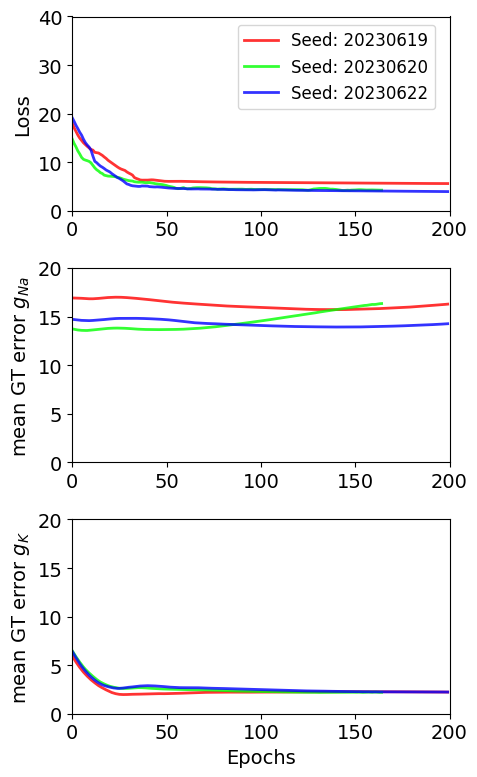

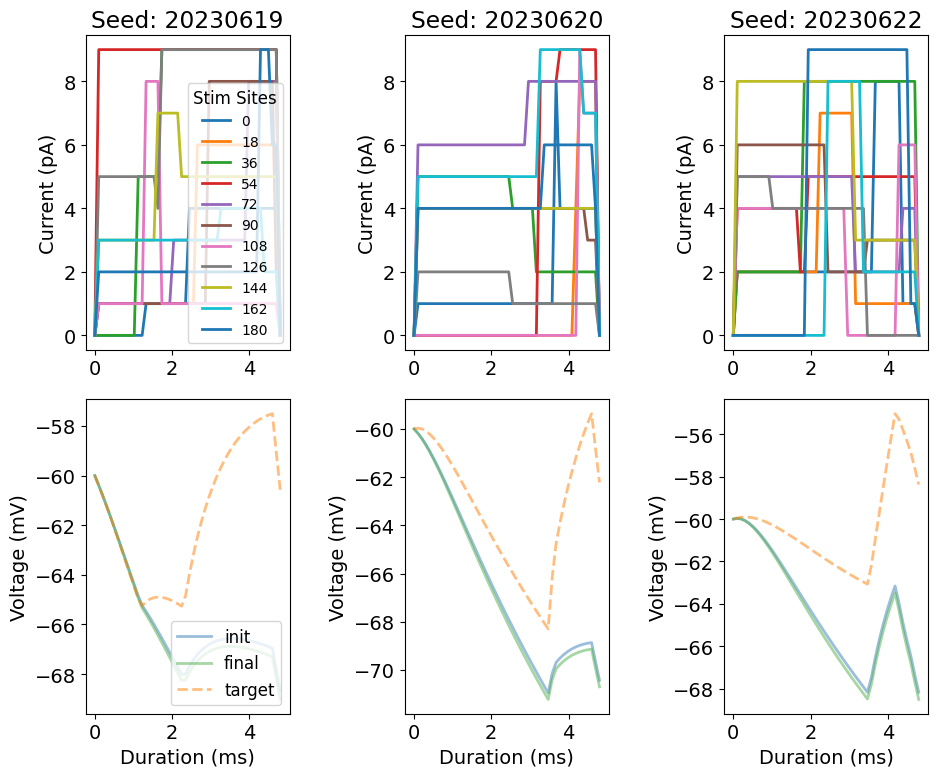

In [14]:
# Arrange condition indexes for plotting purposes
entry_ixs = fig_6_a_selected.index
print(entry_ixs)

# Set hyperparameters
hyperparams = hyperparams_target

# Set xlim for plotting epochs
xlim_epochs = 200

# Set colors for plotting
num_colors = len(entry_ixs)
hues = np.linspace(0, 1, num_colors, endpoint=False)
rgb_colors = [mcolors.hsv_to_rgb([hue, 1.0, 1.0]) for hue in hues]
linewidth = 2
alpha = 0.8

# Figure Plot losses and ground truth errors
fig = plt.figure(figsize=(5, 8))

ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2)
ax4 = plt.subplot(3, 1, 3)

# Figure to Plot currents and voltage outputs
fig2, ax = plt.subplots(2, len(entry_ixs), figsize=(16*3/5, 8))

# Plot each data condition
for i, entry_ix in enumerate(entry_ixs):
    
    #### For Figure 3C ####
    # Load loss and parameter trajectories over training
    loss_curve = torch.load(data_lookup.loc[entry_ix]['loss_filename_id'])
    g_Na_curve = torch.load(data_lookup.loc[entry_ix]['g_Na_filename_id'])
    g_K_curve = torch.load(data_lookup.loc[entry_ix]['g_K_filename_id'])
    
    # Load target parameter generation settings
    center = data_lookup.loc[entry_ix]['mu']
    perturb = data_lookup.loc[entry_ix]['sigma']
    lin_nodes = data_lookup.loc[entry_ix]['lin_nodes']
    seed = data_lookup.loc[entry_ix]['seed']

    stim = data_lookup.loc[entry_ix]['stim_locations']
    rec = data_lookup.loc[entry_ix]['rec_locations']
    noise_sigma = data_lookup.loc[entry_ix]['noise_sigma']
    noise_flag = data_lookup.loc[entry_ix]['flag']

    # Rename "None" conditions to "All"
    if stim == None:
        stim = 'All'
    if rec == None:
        rec = 'All'
    #         print(seed)

    # Generate target paramters
    g_targets = init_random_model_params(hyperparams=hyperparams_model,
                                             center=center,
                                             perturb=perturb,
                                             manual_seed=seed,
                                            )
    
    # Calculate distance between gt and trial params
    scaling = np.array([[100],[45]]) # Original parameter values for g_Na and g_K
    g_targets_scaled = g_targets * scaling
    gt_curve = np.empty((2,len(g_Na_curve)))
    gt_curve[0] = np.mean(np.abs(np.array((g_targets_scaled[0] - g_Na_curve))), 1)
    gt_curve[1] = np.mean(np.abs(np.array((g_targets_scaled[1] - g_K_curve))), 1)
    gt_curve = gt_curve.transpose()

    # Plot Loss
    ax1.plot(loss_curve, 
               linewidth=linewidth,
               label=f"Seed: {seed}",
               color=rgb_colors[i],
               alpha=0.8,
              )
    # Plot g_Na ground truth error trajectory
    ax2.plot(gt_curve[:,0], 
           linewidth=linewidth,
           label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}",
           color=rgb_colors[i],
               alpha=0.8
          )
    # Plot g_K ground truth error trajectory
    ax4.plot(gt_curve[:,1], 
               linewidth=linewidth,
               label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}",
               color=rgb_colors[i],
               alpha=0.8
              )

    #### Plot currents and voltage outputs ####
    
    # Load voltage traces
    volt_traces = load_voltage_traces_by_seed(fig_6_a_selected, 
                                              entry_ix=entry_ix, 
                                              hyperparams_target=hyperparams,
                                              noise_sigma=noise_sigma,
                                              noise_flag=noise_flag,
                                              )
    curr_traces = load_current_traces_by_seed(fig_6_a_selected, 
                                              entry_ix=entry_ix,
                                              hyperparams_target=hyperparams,
                                              noise_sigma=noise_sigma,
                                              noise_flag=noise_flag,
                                             )
    # Buid data frame of loaded voltage traces
    volt_traces_dict = {}
    labels = ['init','final','target']

    for k in range(len(labels)):
        for j in range(len(labels)):
            if labels[k] in (volt_traces[j][0]):
                volt_traces[j][1]
                volt_traces_dict[labels[k]] = volt_traces[j][1]

    volt_traces_df = pd.DataFrame([volt_traces_dict]).T

    # Visualize all voltage traces
    curr = curr_traces[0][1].shape

    volt_init = volt_traces_df.loc['init'][0]
    volt_final = volt_traces_df.loc['final'][0]
    volt_target = volt_traces_df.loc['target'][0]
    duration_volt = torch.linspace(0,len(volt_init[0,0,:,0]),len(volt_init[0,0,:,0])) * 0.1
    duration_curr = torch.linspace(0,curr[2],curr[2]) * 0.1

    neuron_num = 30 # example input/output pair

    # Plot initial somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_init[neuron_num,0,:,0], 
                 color='#377eb8', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='init')
    # plot final somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_final[neuron_num,0,:,0], 
                 color='#4daf4a', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='final')
    # plot target somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_target[neuron_num,0,:,0], 
                 linestyle='dashed', 
                 color='#ff7f00', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='target')
    # plot variable step currents
    for j in stim_rec_locations[0]:
        ax[0,i].plot(duration_curr.reshape(-1,1), 
                     curr_traces[0][1][neuron_num,:,:].transpose(1,0)[:,j], 
                     linewidth=2,
                     label=j)


    # Plot settings
    ax[0,i].set_ylabel('Current (pA)')
    ax[1,i].set_ylabel('Voltage (mV)')
    ax[1,i].set_xlabel('Duration (ms)')
    ax[0,i].set_title(f'Seed: {seed}')
    ax[1,0].legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=12)
    ax[0,0].legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=10, title="Stim Sites", title_fontsize=12)


    ax1.set_ylim(0, 40) 
    ax2.set_ylim(0, 20) 
    ax4.set_ylim(0, 20) 
    ax1.set_xlim(0,xlim_epochs)
    ax2.set_xlim(0,xlim_epochs)
    ax4.set_xlim(0,xlim_epochs)

    ax1.legend(loc='upper center', bbox_to_anchor=(0.7, 1), ncol=1, fontsize=12)

    ax2.set_xlim(0,xlim_epochs)
    ax4.set_xlim(0,xlim_epochs)

    ax1.set_ylabel('Loss')
    ax2.set_ylabel(r'Mean $g_{Na}$')
    ax4.set_ylabel(r'Mean $g_{K}$')

    ax4.set_xlabel('Epochs')


    ax2.set_ylabel(r'mean GT error $g_{Na}$')
    ax4.set_ylabel(r'mean GT error $g_{K}$')

fig.tight_layout()
fig2.tight_layout()


fig_6a_1_filename = 'Fig6a_1.svg'
fig_6a_2_filename = 'Fig6a_2.svg'

fig.savefig(PATH_images+fig_6a_1_filename, format='svg')
fig2.savefig(PATH_images+fig_6a_2_filename, format='svg')

plt.show()

### Table 3: Test Model - Limit Stimulation Sites, Record All Sites

In [15]:
# load loss_curve and calculate gt_curve for each entry_ix

loss_init = []
gt_init_g_Na = []
gt_init_g_K = []
loss_fin = []
gt_fin_g_Na = []
gt_fin_g_K = []

for i, entry_ix in enumerate(entry_ixs):

    loss_curve = torch.load(data_lookup.loc[entry_ix]['loss_filename_id'])
    g_Na_curve = torch.load(data_lookup.loc[entry_ix]['g_Na_filename_id'])
    g_K_curve = torch.load(data_lookup.loc[entry_ix]['g_K_filename_id'])

    center = data_lookup.loc[entry_ix]['mu']
    perturb = data_lookup.loc[entry_ix]['sigma']
    lin_nodes = data_lookup.loc[entry_ix]['lin_nodes']
    seed = data_lookup.loc[entry_ix]['seed']

    stim = data_lookup.loc[entry_ix]['stim_locations']
    rec = data_lookup.loc[entry_ix]['rec_locations']
    noise_sigma = data_lookup.loc[entry_ix]['noise_sigma']
    noise_flag = data_lookup.loc[entry_ix]['flag']

    if stim == None:
        stim = 'All'
    if rec == None:
        rec = 'All'
    #         print(seed)

    g_targets = init_random_model_params(hyperparams=hyperparams_model,
                                             center=center,
                                             perturb=perturb,
                                             manual_seed=seed,
                                            )
    # Calculate distance between gt and trial params

    scaling = np.array([[100],[45]])
    g_targets_scaled = g_targets * scaling
    gt_curve = np.empty((2,len(g_Na_curve)))
    gt_curve[0] = np.mean(np.abs(np.array((g_targets_scaled[0] - g_Na_curve))), 1)
    gt_curve[1] = np.mean(np.abs(np.array((g_targets_scaled[1] - g_K_curve))), 1)
    gt_curve = gt_curve.transpose()

    loss_init.append(loss_curve[0].item())
    loss_fin.append(loss_curve[-1].item())
    gt_init_g_Na.append(gt_curve[0][0].item())
    gt_fin_g_Na.append(gt_curve[-1][0].item())
    gt_init_g_K.append(gt_curve[0][1].item())
    gt_fin_g_K.append(gt_curve[-1][1].item())

In [16]:
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator



# # Initialize an EventAccumulator
# # event_acc_1 = EventAccumulator('./runs/20240430-141344_model_1.0_0.0_target_1.0_0.3_20230619/20240430-171959/events.out.tfevents.1714511999.holygpu8a19602.rc.fas.harvard.edu.2236476.1')
# # event_acc_2 = EventAccumulator('./runs/20240501-001031_model_1.0_0.0_target_1.0_0.3_20230620/20240501-064349/events.out.tfevents.1714560230.holygpu8a19602.rc.fas.harvard.edu.2978394.1')
# # event_acc_3 = EventAccumulator('./runs/20240504-151407_model_1.0_0.0_target_1.0_0.3_20230622/20240504-233100/events.out.tfevents.1714879860.holygpu8a19402.rc.fas.harvard.edu.2909889.1')

# event_acc_1 = EventAccumulator('./runs/20240624-171438_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_20230619/events.out.tfevents.1719263678.holygpu8a19503.rc.fas.harvard.edu.583513.0')
# event_acc_2 = EventAccumulator('./runs/20240624-195621_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_20230620/events.out.tfevents.1719273381.holygpu8a19503.rc.fas.harvard.edu.583513.1')
# event_acc_3 = EventAccumulator('./runs/20240624-222646_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_20230622/events.out.tfevents.1719282406.holygpu8a19503.rc.fas.harvard.edu.583513.2')

# event_acc_list = [event_acc_1, event_acc_2, event_acc_3]
# # event_acc_list = [event_acc_1, event_acc_2]

# walltime_total, walltime_per_epoch, epoch_final = [], [], []

# for event_acc in event_acc_list:
#     # Load the events from the file
#     event_acc.Reload()

#     # Calculate wall time
#     epoch_fin = len(event_acc.Scalars('Total Loss'))
#     wall_time_start = event_acc.Scalars('Total Loss')[0].wall_time
#     wall_time_end = event_acc.Scalars('Total Loss')[-1].wall_time
    
#     # # avg_epoch = event_acc.Scalars('Avg Epoch Duration')[0].value
#     # seconds_t = epoch_fin* avg_epoch

#     # # Convert seconds to hours, minutes, and seconds
#     # hours_t, remainder_t = divmod(seconds_t, 3600)
#     # minutes_t, seconds_t = divmod(remainder_t, 60)


#     # # Convert seconds to hours, minutes, and seconds
#     # hours_e, remainder_e = divmod(avg_epoch, 3600)
#     # minutes_e, seconds_e = divmod(remainder_e, 60)

#     # Convert wall_time to datetime objects
#     start_dt = datetime.datetime.fromtimestamp(wall_time_start)
#     end_dt = datetime.datetime.fromtimestamp(wall_time_end)
    
#     # Calculate the difference
#     time_difference = end_dt - start_dt
    
#     # Extract hours, minutes, and seconds from the time difference
#     total_seconds = time_difference.total_seconds()
#     hours = int(total_seconds // 3600)
#     minutes = int((total_seconds % 3600) // 60)
#     seconds = int(total_seconds % 60)
    
#     # Print the result
#     print(f"Duration: {hours} hours, {minutes} minutes, {seconds} seconds")

#     # # Print the time in hours:minutes:seconds format
#     # print(f"{int(hours_t)}:{int(minutes_t)}:{int(seconds_t)}")
#     # print(f'{int(epoch_fin)}')
#     # print(f'{int(hours_e)}:{int(minutes_e)}:{int(seconds_e)}')

#     # walltime_total.append(f"{int(hours_t)}:{int(minutes_t)}:{int(seconds_t)}")
#     # epoch_final.append(int(epoch_fin))
#     walltime_total.append(f'{int(hours)}:{int(minutes)}:{int(seconds)}')

# print(walltime_total

In [17]:
# conditions_ids = [f'Semi | All']*len(loss_init)

# data_df = pd.DataFrame({
#     # 'Condition S/R'     : conditions_ids,
#     'Seed'          : data_lookup['seed'],
#     'Initial Loss': loss_init,
#     'Final Loss': loss_fin,
#     'Initial g_Na GTE': gt_init_g_Na,
#     'Final g_Na GTE': gt_fin_g_Na,
#     'Initial g_K GTE': gt_init_g_K,
#     'Final g_K GTE': gt_fin_g_K,
#     # 'Total Epochs': epoch_final,
#     'Simulation Time (H:M:S)': walltime_total,
#     # 'Simulation Time Per Epoch (H:M:S)': walltime_per_epoch,
# }, index=entry_ixs).round(3).transpose()

# data_df

# data_df_filename = 'Fig6a_data.csv'
# data_df.to_csv(PATH_images+data_df_filename)

# # print out latex table format of dataframe
# print(data_df.to_latex())
# data_df

In [18]:
# loss_ratio = (1-np.array(loss_fin) / np.array(loss_init))*100
# g_Na_ratio = (1-np.array(gt_fin_g_Na) / np.array(gt_init_g_Na))*100
# g_K_ratio = (1-np.array(gt_fin_g_K) / np.array(gt_init_g_K))*100

# data_df_ratio = pd.DataFrame({
#     'Condition S/R'     : conditions_ids,
#     'Seed'          : data_lookup['seed'],
#     'Initial Loss': loss_init,
#     'Final Loss': loss_fin,
#     'Loss Decrease (%)': loss_ratio,
#     'Initial g_Na GTE': gt_init_g_Na,
#     'Final g_Na GTE': gt_fin_g_Na,
#     'g_Na GTE Decrease (%)': g_Na_ratio,
#     'Initial g_K GTE': gt_init_g_K,
#     'Final g_K GTE': gt_fin_g_K,
#     'g_K GTE Decrease (%)': g_K_ratio,
#     'Total Epochs': epoch_final,
#     'Optimization Time (H:M:S)': walltime_total,
#     'Mean Epoch Time (H:M:S)': walltime_per_epoch,
# }, index=entry_ixs).round(3).transpose()

# data_df_ratio

# data_df_ratio_filename = 'Fig2a_data_ratio.csv'
# data_df_ratio.to_csv(PATH_images+data_df_ratio_filename)

# # print out latex table format of dataframe
# print(data_df_ratio.to_latex())
# data_df_ratio

In [19]:
# Initialize an EventAccumulator
event_acc_1 = EventAccumulator('./runs/20240625-172414_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_20230619/events.out.tfevents.1719350654.holygpu8a19603.rc.fas.harvard.edu.3768859.0')
event_acc_2 = EventAccumulator('./runs/20240625-172414_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_20230619/events.out.tfevents.1719350654.holygpu8a19603.rc.fas.harvard.edu.3768859.0')
event_acc_3 = EventAccumulator('./runs/20240625-224725_stim_0_18_36_54_72_90_108_126_144_162_180_rec_all_20230622/events.out.tfevents.1719370045.holygpu8a19603.rc.fas.harvard.edu.3768859.2')

event_acc_list = [event_acc_1, event_acc_2, event_acc_3]

walltime_total, walltime_per_epoch, epoch_final = [], [], []

for event_acc in event_acc_list:
    # Load the events from the file
    event_acc.Reload()

    # Calculate wall time
    epoch_fin = len(event_acc.Scalars('Total Loss'))
    wall_time_start = event_acc.Scalars('Total Loss')[0].wall_time
    wall_time_end = event_acc.Scalars('Total Loss')[-1].wall_time
    
    # # avg_epoch = event_acc.Scalars('Avg Epoch Duration')[0].value
    # seconds_t = epoch_fin* avg_epoch

    # # Convert seconds to hours, minutes, and seconds
    # hours_t, remainder_t = divmod(seconds_t, 3600)
    # minutes_t, seconds_t = divmod(remainder_t, 60)


    # # Convert seconds to hours, minutes, and seconds
    # hours_e, remainder_e = divmod(avg_epoch, 3600)
    # minutes_e, seconds_e = divmod(remainder_e, 60)

    # Convert wall_time to datetime objects
    start_dt = datetime.datetime.fromtimestamp(wall_time_start)
    end_dt = datetime.datetime.fromtimestamp(wall_time_end)
    
    # Calculate the difference
    time_difference = end_dt - start_dt
    
    # Extract hours, minutes, and seconds from the time difference
    total_seconds = time_difference.total_seconds()
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    
    # Print the result
    print(f"Duration: {hours} hours, {minutes} minutes, {seconds} seconds")

    epoch_final.append(int(epoch_fin))
    walltime_total.append(f'{int(hours)}:{int(minutes)}:{int(seconds)}')

print(walltime_total)

Duration: 3 hours, 1 minutes, 47 seconds
Duration: 3 hours, 1 minutes, 47 seconds
Duration: 3 hours, 8 minutes, 34 seconds
['3:1:47', '3:1:47', '3:8:34']


In [20]:
conditions_ids = [f'Semi | All']*len(loss_init)

data_df = pd.DataFrame({
    # 'Condition S/R'     : conditions_ids,
    'Seed'          : data_lookup['seed'],
    'Initial Loss': loss_init,
    'Final Loss': loss_fin,
    'Initial g_Na GTE': gt_init_g_Na,
    'Final g_Na GTE': gt_fin_g_Na,
    'Initial g_K GTE': gt_init_g_K,
    'Final g_K GTE': gt_fin_g_K,
    # 'Total Epochs': epoch_final,
    'Simulation Time (H:M:S)': walltime_total,
    # 'Simulation Time Per Epoch (H:M:S)': walltime_per_epoch,
}, index=entry_ixs).round(3).transpose()

data_df

data_df_filename = 'Fig6a_data.csv'
data_df.to_csv(PATH_images+data_df_filename)

# print out latex table format of dataframe
print(data_df.to_latex())
data_df

\begin{tabular}{llll}
\toprule
{} &         0 &         1 &         2 \\
\midrule
Seed                    &  20230619 &  20230620 &  20230622 \\
Initial Loss            &    18.052 &    14.812 &    19.174 \\
Final Loss              &       5.6 &     4.245 &     3.947 \\
Initial g\_Na GTE        &    16.914 &     13.73 &    14.715 \\
Final g\_Na GTE          &    16.277 &    16.337 &     14.26 \\
Initial g\_K GTE         &     5.975 &     6.501 &     6.434 \\
Final g\_K GTE           &     2.225 &     2.203 &     2.233 \\
Simulation Time (H:M:S) &    3:1:47 &    3:1:47 &    3:8:34 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2796903/3262909552.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_df.to_latex())


,0,1,2
Seed,20230619,20230620,20230622
Initial Loss,18.052,14.812,19.174
Final Loss,5.6,4.245,3.947
Initial g_Na GTE,16.914,13.73,14.715
Final g_Na GTE,16.277,16.337,14.26
Initial g_K GTE,5.975,6.501,6.434
Final g_K GTE,2.225,2.203,2.233
Simulation Time (H:M:S),3:1:47,3:1:47,3:8:34


#### Final Table

In [22]:
loss_ratio = (1-np.array(loss_fin) / np.array(loss_init))*100
g_Na_ratio = (1-np.array(gt_fin_g_Na) / np.array(gt_init_g_Na))*100
g_K_ratio = (1-np.array(gt_fin_g_K) / np.array(gt_init_g_K))*100

data_df_ratio = pd.DataFrame({
    # 'Condition S/R'     : conditions_ids,
    'Seed'          : data_lookup['seed'],
    'Initial Loss': loss_init,
    'Final Loss': loss_fin,
    'Loss Decrease (%)': loss_ratio,
    'Initial g_Na GTE': gt_init_g_Na,
    'Final g_Na GTE': gt_fin_g_Na,
    'g_Na GTE Decrease (%)': g_Na_ratio,
    'Initial g_K GTE': gt_init_g_K,
    'Final g_K GTE': gt_fin_g_K,
    'g_K GTE Decrease (%)': g_K_ratio,
    # 'Total Epochs': epoch_final,
    'Optimization Time (H:M:S)': walltime_total,
    # 'Mean Epoch Time (H:M:S)': walltime_per_epoch,
}, index=entry_ixs).round(3).transpose()

data_df_ratio

data_df_ratio_filename = 'Fig2a_data_ratio.csv'
data_df_ratio.to_csv(PATH_images+data_df_ratio_filename)

# print out latex table format of dataframe
print(data_df_ratio.to_latex())
data_df_ratio

\begin{tabular}{llll}
\toprule
{} &         0 &         1 &         2 \\
\midrule
Seed                      &  20230619 &  20230620 &  20230622 \\
Initial Loss              &    18.052 &    14.812 &    19.174 \\
Final Loss                &       5.6 &     4.245 &     3.947 \\
Loss Decrease (\%)         &    68.977 &    71.343 &    79.413 \\
Initial g\_Na GTE          &    16.914 &     13.73 &    14.715 \\
Final g\_Na GTE            &    16.277 &    16.337 &     14.26 \\
g\_Na GTE Decrease (\%)     &     3.763 &   -18.987 &     3.091 \\
Initial g\_K GTE           &     5.975 &     6.501 &     6.434 \\
Final g\_K GTE             &     2.225 &     2.203 &     2.233 \\
g\_K GTE Decrease (\%)      &    62.755 &    66.107 &    65.302 \\
Total Epochs              &       200 &       200 &       200 \\
Optimization Time (H:M:S) &    3:1:47 &    3:1:47 &    3:8:34 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2796903/3177226968.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_df_ratio.to_latex())


,0,1,2
Seed,20230619,20230620,20230622
Initial Loss,18.052,14.812,19.174
Final Loss,5.6,4.245,3.947
Loss Decrease (%),68.977,71.343,79.413
Initial g_Na GTE,16.914,13.73,14.715
Final g_Na GTE,16.277,16.337,14.26
g_Na GTE Decrease (%),3.763,-18.987,3.091
Initial g_K GTE,5.975,6.501,6.434
Final g_K GTE,2.225,2.203,2.233
g_K GTE Decrease (%),62.755,66.107,65.302
